In [3]:
import pandas as pd
import numpy as np
from kafkanator import gini,lorentz_curve
import matplotlib.pyplot as pyplt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

<h1> Description </h1>
<br/>
This notebook assigns a discriminative score to the defined sensitive attributes of a population. For this example
the population is a set of attributes corresponding to the artists of our coolsongs.com web app example.
<br/>
<br/>
This discriminative score, gives you an idea of how fair your recommendation algorithm is doing with respect to those sensitive values.
<br/>
You could potentially use this notebook on any recommendation system making the tuning that every business need.
You should have two data frames.
<h2>Dataframe 1 :</h2> An  output list of recommendations for a query, as ranking comma separated (see rankings). The artist identificators in the ranking cant repeat.
<h2>Dataframe 2 :</h2> The sensitive attributes of your population.(sens_attr)

In [4]:
# Df and join are two dataframes 

In [5]:
rankings = pd.read_csv('./data/ranking.csv',sep=',',header=0)
sens_attr = pd.read_csv('./data/artist_join_sens_attr.csv',sep=',',header=0)

In [6]:
rankings

,query,Rankings
0,1,"2,5,7,10,12"
1,2,"1,6,7,5,8"
2,3,"5,7,9,10,12"
3,4,"14,5,10,2,1"
4,5,"2,8,9,10,1"
5,6,"4,6,7,9,10"
6,7,"13,5,9,15,16"
7,8,"17,5,6,18,1"
8,9,"1,2,3,4,5"
9,10,"20,19,18,17,14"


In [7]:
sens_attr

,artist_id,age,gender,nationality
0,1,20,M,national
1,2,52,F,foreign
2,3,36,M,national
3,4,25,F,foreign
4,5,67,M,national
5,6,45,F,foreign
6,7,59,M,national
7,8,23,F,foreign
8,9,18,M,national
9,10,56,F,foreign


In [8]:
sensitive_attributes = [ 'nationality','gender' ]
id_column = 'artist_id'

In [9]:
sensitive_columns = sens_attr[sensitive_attributes].merge(sens_attr[id_column].to_frame(),left_index=True, right_index=True)

In [10]:
sensitive_columns

,nationality,gender,artist_id
0,national,M,1
1,foreign,F,2
2,national,M,3
3,foreign,F,4
4,national,M,5
5,foreign,F,6
6,national,M,7
7,foreign,F,8
8,national,M,9
9,foreign,F,10


<h1> Score hash initialization </h1>
<br/>
This loop initializes a dictionnary containing keys as column names and values dictionnaries of each possible value in the column. For the moment it only works with categorical variables.

In [11]:
counters_sens_attributes = {}
for s in sensitive_attributes: 
    theKeys = set(sensitive_columns[s])
    theValues = 0
    senses_dict = dict.fromkeys(theKeys, theValues)
    counters_sens_attributes[s] = senses_dict

In [12]:
counters_sens_attributes

{'nationality': {'foreign': 0, 'national': 0}, 'gender': {'F': 0, 'M': 0}}

<h1>Score hash algorithm</h1>

<i>sensitive_columns</i> dataframe contains the sensitive information (information that could be source of discrimination) in the artist population that is making the content generation for the example web app coolsongs.com.
<br/>
<br/>
As a general description, <b>algorithm 2</b> parses each line of the rankings dataframe, each line is a comma-separated string containing a list of artist identifiers, as is a ranking, the order is important meaning that the first position is somehow more important than the second according to a business defined score.

The idea is, for each artist k in a dataset containing n artists, the artist recommended score (RA) will compute how recommended this artist is by computing.
<br/>
<br/>
<center>$RA_k$ = $ \sum_{i=1}^{n} (  N - pos_i(Artist_k) ) $.</center>

Being pos(Artist) the position of the artist in the list located in row i.

The artist recommended score $RA_k$ can be splitted over the values of a categorical sensitive column :
So for a sensitive categorical column S that could be any of Sj possibilities $\{S_1,S_2,S_3, ... , S_p\}$
we have :
<center>$SC_j = \sum_{i=1}^{n} ( if Artist_k(S) == S_j  : N - pos_i(Artist_k) ) $.</center>
And you must have : 
<br/>
<br/>
<center> $\sum_{j=1}^{n} ( SC_j ) = \sum_{j=1}^{n} ( if Artist_k(S) == j : RA_k ) $ [2] </center> 
<br/>
<br/>
The summatory results will be stored in <i>rock_artist</i> variable.

<b> Algorithm 2 : Recommended Score computing . $( RA_k )$, output is stored in rock_artists. </b>

In [13]:
rock_artists = {}
for i in range(1,21):
    rock_artists[i] = 0
# Take the ranking column
for r in rankings["Rankings"].values:
    seq = r.split(',')
    # Take each position of the ranking, find the artist id and add
    # that score, the same for each sensitive artist attribute.
    N = len(seq)
    scoring = list(range(1,N+1))
    scoring.reverse()
    together = list(zip(scoring,seq))
    print(together)
    for (pos,s) in together:
        rock_artists[int(s)] = rock_artists[int(s)] + pos
        for a in sensitive_attributes:
            value_of_attribute = sensitive_columns[sensitive_columns[id_column]==int(s)][a] 
            counters_sens_attributes[a][ value_of_attribute.item() ] = counters_sens_attributes [  a  ][ value_of_attribute.item() ] + pos

[(5, '2'), (4, '5'), (3, '7'), (2, '10'), (1, '12')]
[(5, '1'), (4, '6'), (3, '7'), (2, '5'), (1, '8')]
[(5, '5'), (4, '7'), (3, '9'), (2, '10'), (1, '12')]
[(5, '14'), (4, '5'), (3, '10'), (2, '2'), (1, '1')]
[(5, '2'), (4, '8'), (3, '9'), (2, '10'), (1, '1')]
[(5, '4'), (4, '6'), (3, '7'), (2, '9'), (1, '10')]
[(5, '13'), (4, '5'), (3, '9'), (2, '15'), (1, '16')]
[(5, '17'), (4, '5'), (3, '6'), (2, '18'), (1, '1')]
[(5, '1'), (4, '2'), (3, '3'), (2, '4'), (1, '5')]
[(5, '20'), (4, '19'), (3, '18'), (2, '17'), (1, '14')]


In [14]:
rock_artists

{1: 13,
 2: 16,
 3: 3,
 4: 7,
 5: 24,
 6: 11,
 7: 13,
 8: 5,
 9: 11,
 10: 10,
 11: 0,
 12: 2,
 13: 5,
 14: 6,
 15: 2,
 16: 1,
 17: 7,
 18: 5,
 19: 4,
 20: 5}

<b> Code in two boxes below help to ensure equality in [2], you can change the column and value parameters and check
that the equality holds. </b>

In [15]:
def get_indexes_of_sensitive_category(column,value):
    indexes = sensitive_columns[sensitive_columns[column] == value]['artist_id'].values
    return indexes

def sum_score_index(indexes):
    sumNationals = 0
    for i in range(0, len(indexes)):
        #print(indexes[i], ' ', rock_artists[ indexes[i] ])
        sumNationals = sumNationals + rock_artists[ indexes[i] ]
    return sumNationals

In [16]:
indexes_man  = get_indexes_of_sensitive_category('gender','M')
indexes_women = get_indexes_of_sensitive_category('gender','F')

indexes_nationals = get_indexes_of_sensitive_category('nationality','national')
indexes_foreigners = get_indexes_of_sensitive_category('nationality','foreign')

In [17]:
print ( indexes_man )
print ( indexes_women )

print( indexes_nationals )
print ( indexes_foreigners )

[ 1  3  5  7  9 11 13 15 17 19]
[ 2  4  6  8 10 12 14 16 18 20]
[ 1  3  5  7  9 11 13 15 16 17 18 19 20]
[ 2  4  6  8 10 12 14]


In [18]:
sum_nationals = sum_score_index(indexes_nationals)
sum_foreigners = sum_score_index(indexes_foreigners)

sum_man = sum_score_index(indexes_man)
sum_women = sum_score_index(indexes_women)

print ( sum_nationals )
print ( sum_foreigners)
print ( sum_man)
print ( sum_women)

93
57
82
68


In [19]:
counters_sens_attributes

{'nationality': {'foreign': 57, 'national': 93}, 'gender': {'F': 68, 'M': 82}}

In [20]:
scoring_gains_sorted = sorted([y for (x,y) in list( rock_artists.items() )])
sensitives = []
for k,sensitive in counters_sens_attributes.items():
    sens_gain_sorted= sorted([y for (x,y) in list( sensitive.items() )])
    sensitives.append(sens_gain_sorted)

In [21]:
scoring_gains_sorted

[0, 1, 2, 2, 3, 4, 5, 5, 5, 5, 6, 7, 7, 10, 11, 11, 13, 13, 16, 24]

In [22]:
gini(np.array(scoring_gains_sorted))

0.4073333333333333

In [23]:
gns = list(map(gini,np.array(sensitives)))

In [24]:
sensitives

[[57, 93], [68, 82]]

In [25]:
gns

[0.12, 0.04666666666666667]

In [26]:
lorentz_score_x,lorentz_score_y = lorentz_curve(np.repeat(1,20),scoring_gains_sorted)
lorentz_gender_x,lorentz_gender_y = lorentz_curve(np.repeat(1,2),sensitives[0])
lorentz_nation_x,lorentz_nation_y = lorentz_curve(np.repeat(1,2),sensitives[1])

 sorted array  [(1, 0), (1, 1), (1, 2), (1, 2), (1, 3), (1, 4), (1, 5), (1, 5), (1, 5), (1, 5), (1, 6), (1, 7), (1, 7), (1, 10), (1, 11), (1, 11), (1, 13), (1, 13), (1, 16), (1, 24)]
 sorted array  [(1, 57), (1, 93)]
 sorted array  [(1, 68), (1, 82)]


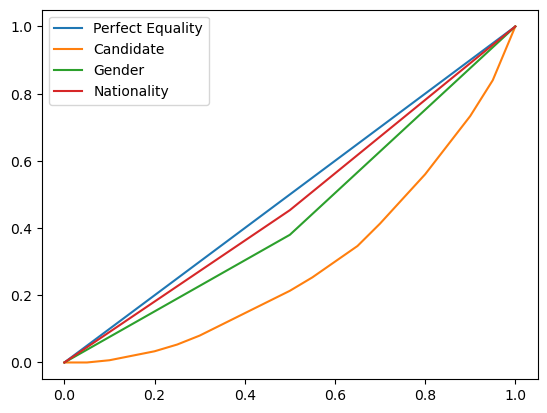

In [28]:
pyplt.plot([0,1], [0,1])
pyplt.plot(lorentz_score_x,lorentz_score_y)
pyplt.plot(lorentz_gender_x,lorentz_gender_y)
pyplt.plot(lorentz_nation_x,lorentz_nation_y)
pyplt.legend(['Perfect Equality','Candidate','Gender', 'Nationality'])